In [1]:
import json
import pandas as pd
from pandas._libs.tslibs.timedeltas import Timedelta as td
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

pd.set_option('display.max_row', None)
pd.set_option('display.max_column', None)

# data load

In [3]:
data = pd.read_excel('base_data.xlsx', index_col= [0])
data.drop(['first day', 'last day'], axis = 1, inplace = True)

## 전작 드라마 찾기
#### 조건 1: 전작과 후속작의 방송사, 방송요일은 같아야 한다
#### 조건 2: 후속작은 전작 종영후 24일 안에 첫방송한다. (24일은 경험적으로 선택)
#### 조건 3: 동시간대는 1시간 30분 이내로 전제한다 (특정 방송사의 드라마 시간대 이동으로 동시간-후속작이 최대 1시간 20분까지 차이가 남)

In [4]:
drama_name = []
pre_rating = []

for i, next_drama in data.iterrows():
    
    # 조건1 : 방송사과 방송요일은 같아야 한다.
    next_factor = [next_drama['방송사'], next_drama['요일']]
    next_time_factor = '{h}:{m}:00'.format(h=next_drama['시'], m=next_drama['분'])
    start = next_drama['방송시작']
    
    for ii, pre_drama in data.iterrows():
        pre_factor = [pre_drama['방송사'], pre_drama['요일']]
        pre_time_factor = '{h}:{m}:00'.format(h=pre_drama['시'], m=pre_drama['분'])
        end = pre_drama['방송종영']
        
        # 조건2: 후속작은 24일 안에 첫방송을 실시한다 (24일은 주관적인 값)
        diff = abs(start - end)
        expected_diff = td('24 days')
        
        # 조건3: 방송 시간대가 1시간 30분 차이 이내면 동시간대로 본다
        # *(몇몇 방송사가 드라마 시간대를 이동했기 때문에 1시간 30분을 설정)
        time_diff = abs(td(pre_time_factor) - td(next_time_factor))
        expected_time_diff = td('1:30:00')
            
        # 조건1 and 자기중복방지
        if pre_factor == next_factor and pre_drama.name != next_drama.name:
            
            #조건2 and 조건3
            if diff < expected_diff and time_diff < expected_time_diff:
                
                drama_name.append(i)
                pre_rating.append(pre_drama['last rating'])
                

In [5]:
last_of_pre=pd.DataFrame(pre_rating, index=drama_name, columns=['last of pre'])
total_data = data.join(last_of_pre)

### Preprocessing 요일
정리되있지 않은 요일 데이터를 정리

In [6]:
for i, drama in total_data.iterrows():
    day = drama['요일']
    if day.endswith('요'):
        total_data.at[i,'요일'] = day.strip('요')
    elif day == '불금':
        total_data.at[i,'요일'] = '금'

### Encoding 시즌, 전편, 원작
시즌 유무, 전편 유무, 원작 유무에 따라 0,1,로 표현 (없음:0, 있음:1)

In [7]:
total_data['시즌'].unique()
total_data['시즌']= np.where(total_data['시즌']=='-', 0, 1)
total_data['전편']= np.where(total_data['전편']=='-', 0, 1)
total_data['원작']= np.where(total_data['원작']=='-', 0, 1)
total_data['분할방송']= np.where(total_data['분할방송']==2, 1, 0)

### Encoding 요일
방송 요일별로 표시함 (ex. 월화 - 1100000, 일 - 0000001)

In [8]:
day_array = []
for i, data in total_data.iterrows():
    day = np.array([0, 0, 0, 0, 0, 0, 0])
    if '월' in data['요일']:
        day[0] = 1
    if '화' in data['요일']:
        day[1] = 1
    if '수' in data['요일']:
        day[2] = 1
    if '목' in data['요일']:        
        day[3] = 1
    if '금' in data['요일']:    
        day[4] = 1
    if '토' in data['요일']:    
        day[5] = 1
    if '일' in data['요일']:   
        day[6] = 1
    day_array.append(day)

day_array = np.array(day_array)
day_of_week = pd.DataFrame(day_array, columns=['월', '화', '수', '목', '금', '토', '일'], index = total_data.index)
total_data = total_data.join(day_of_week)

### Encoding 방송사

In [9]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore')
company = pd.DataFrame(ohe.fit_transform(total_data[['방송사']]).toarray(), 
             columns=[i.strip('_') for i in ohe.get_feature_names([''])], 
             index = total_data.index)
total_data = total_data.join(company)

### 사용하지 않는 columns 를 지워주기

In [10]:
processed = total_data.drop(['장르','요일','시','분','연도','분량','방송시작','방송종영','부작','제작사','방송사'], axis = 1)

In [11]:
processed.columns = ['mean rating', 'split', 'season', 'previous drama',
                     'original drama', 'first rating', 'last rating',
                     'last of pre','Mon','Tue','Wed','Thu','Fri','Sat','Sun',
                     'JTBC', 'KBS W', 'KBS1', 'KBS2', 'MBC', 'MBC every1', 'MBN',
                     'MBN dramax', 'OCN', 'Olive', 'SBS', 'TV chosun', 'XtvN', 'tvN', 'tvn', 'dramax MBN', 'channel A']

## Heatmap

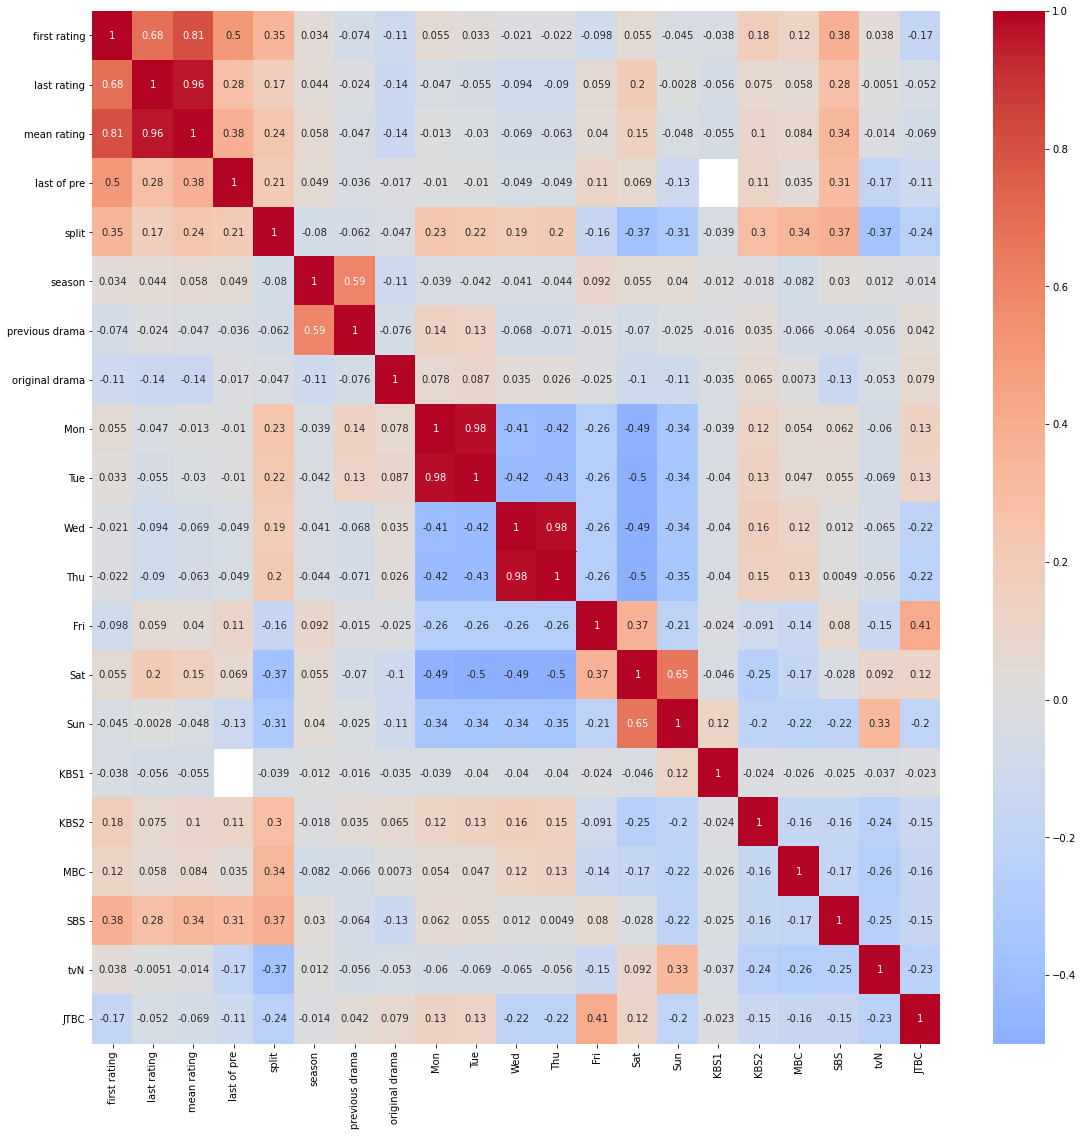

In [12]:
plt.figure(figsize = (19,19))
sns.heatmap(processed[['first rating','last rating','mean rating', 'last of pre','split', 'season', 'previous drama',
                     'original drama', 'Mon','Tue','Wed','Thu','Fri','Sat','Sun','KBS1', 'KBS2', 'MBC',
                      'SBS', 'tvN', 'JTBC']].corr() , annot=True, center=0, cmap = 'coolwarm')

## Heatmap 분석
#### Heatmap을 통해 상관관계를 파악해보려했다. 하지만 눈에 띄는 요소를 찾지 못했다. 특히, 우리가 예측하려는 첫방송 시청률과 다른 요소들간의 상관관계는 특이한 점이 없어 보였다. 상관관계가 절댓값 0.1 이상인 요소를 찾아보면 방송사-[SBS, JTBC, MBC, KBS2], 시청률-[막방, 평균, 전작 마지막 시청률], 이외 요소-[원작유무, 분할방송] 등이 있었다. 특이한점은 SBS의 첫방송 시청률과 높은 상관관계를 보였다. SBS 드라마의 첫방 시청률이 다른 방송사보다 높다는 이야기다. 그리고 분할 방송을 할 때 첫 방송의 시청률이 높게 나왔다. 이부분은 어떻게 해석해야 할지 모르겠다. 원작의 유무와 첫방송 시청률간에 상관관계가 있다는 것은 쉽게 이해된다.

## scaling
train_data : 스케일링하지 않은 데이터  
scaled_train_data : 스케일링한 데이터  

#### 스케일링한 데이터와 하지 않은 데이터를 나눈 이유는, 예측해야 하는 드라마는 1개인데 데이터 1개를 스케일링 할 방법을 몰랐고 스케일링한 데이터와 그렇지 않은 데이터를 학습시켰을 때 어떤 차이가 있는지 궁금했기 때문이다.

In [13]:
from sklearn.preprocessing import scale

np.random.seed(0)

target_data = processed[['first rating']]
features_data = processed.drop(['first rating','mean rating','last rating'], axis=1)
print(features_data.columns)
features_data.fillna(processed['last of pre'].mean(), inplace =True)
scaled = pd.DataFrame(scale(features_data), index = features_data.index)

train_data = pd.concat([target_data, features_data], axis =1)
scaled_train_data = pd.concat([target_data, scaled], axis = 1)

Index(['split', 'season', 'previous drama', 'original drama', 'last of pre',
       'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'JTBC', 'KBS W',
       'KBS1', 'KBS2', 'MBC', 'MBC every1', 'MBN', 'MBN dramax', 'OCN',
       'Olive', 'SBS', 'TV chosun', 'XtvN', 'tvN', 'tvn', 'dramax MBN',
       'channel A'],
      dtype='object')


# 학습시키기

## 모델생성 (non-scaled)

In [13]:
X = train_data.loc[:, train_data.columns != 'first rating']
y = train_data.loc[:, 'first rating']

In [14]:
import os
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tqdm.keras import TqdmCallback
from tqdm.notebook import tqdm
from keras.models import Sequential
from keras.layers import Dense
import keras

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

model = Sequential()
model.add(Dense(128, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               3840      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 14,449
Trainable params: 14,449
Non-trainable params: 0
_________________________________________________________________


## 훈련 (non-scaled)
#### 학습은 10회 학습을 총 300 set 반복한다. for 문을 쓰는 이유는 10회마다 model이 테스트 데이터를 얼마나 정확히 예측하는지를 측정하기 위함이다. 따라서 X 축은 10회 즉, 1set 단위로 이루어져 있다.

In [15]:
%time
train_rmse = []
test_rmse = []

for i in tqdm(range(300)):
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    model.fit(X_train, y_train, epochs=10, verbose=0)
    
    train_pred = model.predict(X_train)
    train_rmse.append(np.sqrt(mean_squared_error(y_train, train_pred)))

    test_pred = model.predict(X_test)
    test_rmse.append(np.sqrt(mean_squared_error(y_test, test_pred)))

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.3 µs


## 모델 학습 결과 (non-scaled)

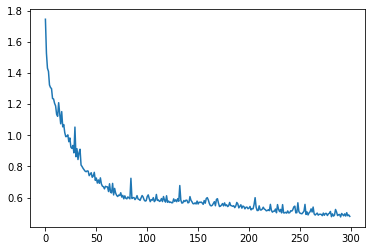

In [16]:
plt.plot(train_rmse)

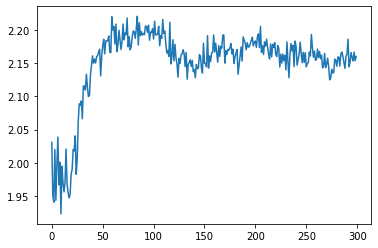

In [17]:
plt.plot(test_rmse)

## 모델 생성 및 훈련 (scaled)

In [18]:
train_data = scaled_train_data

X = train_data.loc[:, train_data.columns != 'first rating']
y = train_data.loc[:, 'first rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

model = Sequential()
model.add(Dense(128, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               3840      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 14,449
Trainable params: 14,449
Non-trainable params: 0
_________________________________________________________________


In [19]:
%time
train_rmse = []
test_rmse = []

for i in tqdm(range(300)):
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    model.fit(X_train, y_train, epochs=10, verbose=0)
    
    train_pred = model.predict(X_train)
    train_rmse.append(np.sqrt(mean_squared_error(y_train, train_pred)))

    test_pred = model.predict(X_test)
    test_rmse.append(np.sqrt(mean_squared_error(y_test, test_pred)))

CPU times: user 177 µs, sys: 5 µs, total: 182 µs
Wall time: 362 µs


## 모델 학습 결과 (scaled)

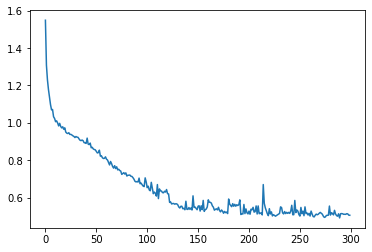

In [20]:
plt.plot(train_rmse)

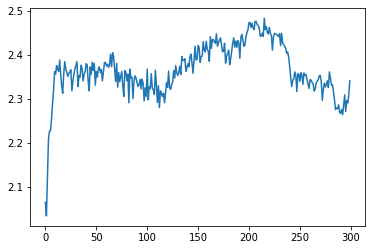

In [21]:
plt.plot(test_rmse)

#### 위의 학습은 3000 epoch로 설정이 되어있다. 특이한 점은 스케일링을 했음과 관계없이 두가지 경우 모두 학습 초기에 가장 낮은 test_rmse를 보인다는 것이다. 3000번 이상 학습했을때 test_rmse가 계속해서 작아지는지를 살펴보고 최적의 학습횟수를 추측해 보자.  

다음 결과는 Ram 용량의 초과로 인해 Kaggle에서 학습시키고 난 결과를 이미지로 불러왔다. 

### Scaled data

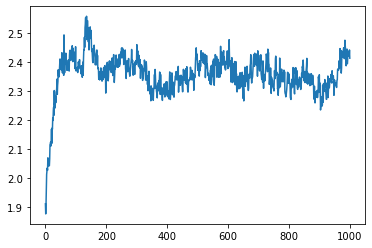

In [26]:
from IPython.display import Image
Image('scaled_10000_epoch.png')

#### 총 학습횟수는 10000 epoch 이다. 1000 set x 10 epoch로 학습시키면서 model의 test_rmse 값을 추적했다. scaled data 를 10000번 학습을 진행할때 최소 test_rmse값을 갖는 epoch 횟수는 10이었다.

### Non-Scaled data

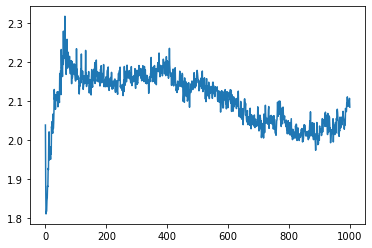

In [28]:
Image('non_scaled_10000_epoch.png')

 #### 방법은 위와 동일하다. Non-scaled data 를 10000번 학습을 진행할때 최소 test_rmse값을 갖는 epoch 횟수는 20이었다.

# 결론
### 1. 초기 학습 시점(10-20 epoch)에서 최소 test_rmse를 얻을 수 있다.
### 2. Non-scaled data를 학습했을 때 비교적 더 작은 test_rmse를 얻을 수 있다.


# 제한점
###  같은 random seed 값을 사용하고 있기 때문에 다른 seed 값들에서도 동일한 결과가 나오는지 살펴 볼 필요가 있다. random seed 값을 변경해서 위와 같은 결론이 타당한지 탐구해야 한다.